[Reference](https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b)

In [4]:
pip install eif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 
  Created wheel for eif: filename=eif-2.0.2-cp38-cp38-linux_x86_64.whl size=262222 sha256=b0e6d8c33e5f0b1f01b87770a898917329c5b5bbb0accf4eb9f0dfdbb2834f0f
  Stored in directory: /root/.cache/pip/wheels/09/03/7b/a12d773555eff50431637ce26cbcc2b1b9c582c8b09b2d8350
Successfully built eif


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import multivariate_normal

from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import euclidean_distances
import eif as iso

# default plot settings
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Anomaly_Detection

Mounted at /content/drive
/content/drive/MyDrive/Medium


In [12]:
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_truth, y_pred)))
    print('Precision: {:.4f}'.format(metrics.precision_score(y_truth, y_pred)))
    print('Recall: {:.4f}'.format(metrics.recall_score(y_truth, y_pred)))
    print('F1: {:.4f}'.format(metrics.f1_score(y_truth, y_pred)))

In [17]:
mat = scipy.io.loadmat('cover.mat')
X = pd.DataFrame(mat['X'])
y = pd.Series([x[0] for x in mat['y']])

In [18]:
X.shape

(286048, 10)

In [19]:
X.describe()

,0,1,2,3,4,5,6,7,8,9
count,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000
mean,2914.242610,151.917224,13.598309,278.255251,45.839107,2414.978643,213.983685,225.246605,142.680092,2155.583857
std,197.987324,107.488551,7.138464,210.458091,57.504597,1618.090012,24.955931,18.551910,36.501454,1423.976520
min,1988.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2788.000000,60.000000,8.000000,120.000000,8.000000,1123.000000,201.000000,215.000000,120.000000,1165.000000
50%,2933.000000,126.000000,13.000000,240.000000,30.000000,2016.000000,219.000000,227.000000,142.000000,1832.000000
75%,3041.000000,241.000000,18.000000,390.000000,67.000000,3386.000000,232.000000,239.000000,167.000000,2647.000000
max,3433.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


In [20]:
# define % of anomalies
anomalies_ratio = 0.009

if_sk = IsolationForest(n_estimators = 100, 
                        max_samples = 256,
                        contamination = anomalies_ratio, 
                        # behaviour= " new", 
                        random_state = np.random.RandomState(42))
if_sk.fit(X)
y_pred = if_sk.predict(X)
y_pred = [1 if x == -1 else 0 for x in y_pred]

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9830
Precision: 0.0882
Recall: 0.0826
F1: 0.0853


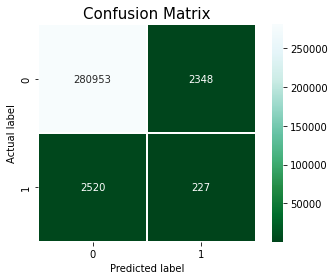

In [21]:
pretty_cm(y_pred, y, [0, 1])

In [28]:
if_eif = iso.iForest(X.values.astype('double'), 
                     ntrees = 100, 
                     sample_size = 256, 
                     ExtensionLevel = 0)

# calculate anomaly scores
anomaly_scores = if_eif.compute_paths(X_in = X.values.astype('double'))
# sort the scores
anomaly_scores_sorted = np.argsort(anomaly_scores)
# retrieve indices of anomalous observations
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(anomalies_ratio * X.shape[0])):]
# create predictions 
y_pred = np.zeros_like(y)
y_pred[indices_with_preds] = 1

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9831
Precision: 0.0936
Recall: 0.0877
F1: 0.0906


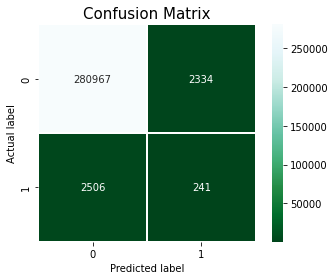

In [29]:
pretty_cm(y_pred, y, [0, 1])

In [26]:
eif = iso.iForest(X.values.astype('double'), 
                  ntrees = 100, 
                  sample_size = 256, 
                  ExtensionLevel = X.shape[1] - 1)

anomaly_scores = eif.compute_paths(X_in = X.values.astype('double'))
anomaly_scores_sorted = np.argsort(anomaly_scores)
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(anomalies_ratio * X.shape[0])):]
y_pred = np.zeros_like(y)
y_pred[indices_with_preds] = 1

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9814
Precision: 0.0000
Recall: 0.0000
F1: 0.0000


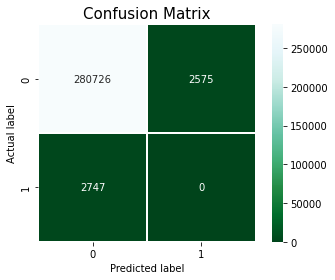

In [27]:
pretty_cm(y_pred, y, [0, 1])